In [1]:
import os
import pickle
import glob
import skimage
import skimage.transform
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

import sys

sys.path.append('../functions')

import chirp_functions as proc
%matplotlib inline

In [2]:
! which python

/Users/jiatongyang/opt/anaconda3/bin/python


In [3]:
## STEP 1: PREPROCESS DATA
proc.preprocess_chirp(data_dir = '../../data/kagome-02.26.2022-center/raw/real_space/', 
                       frequencies = np.linspace(1000.0, 18000.0, 426), 
                       targetfile = '../../data/kagome-02.26.2022-center/preprocessed_real/', 
                       title = 'scppos_', setno = 0)

Found 164 records
Preprocessing complete!


In [4]:
## 2D fourier transform - NEW!!!!!

from tqdm import tqdm

folder = "../../data/kagome-02.26.2022-center/"

with open(folder + "preprocessed_band/_13000.0_0.pkl",'rb') as f:
    real_data = pickle.load(f)

#print(real_data)

#L_kag = 0.008
#L = L_kag*np.sqrt(3)/2*(np.sqrt(3)+1)
L = 0.01
kxmax = 4*np.pi/(3*np.sqrt(3) * L)
kymax = 2*np.pi/(3*L)
kxs = np.linspace(-2*kxmax, 2*kxmax, 80)
kys = np.linspace(-2*kymax, 2*kymax, 80)

#print(L)

G = [[0.0, 0.0], [6*np.pi/(3*np.sqrt(3) * L), 2*np.pi/(3*L)], [6*np.pi/(3*np.sqrt(3) * L), -2*np.pi/(3*L)], [0, 4*np.pi/(3*L)]]
#print(G[1][0])

reciprocal_data = np.zeros((len(kxs), len(kys)))
reciprocal_raw = np.zeros((len(kxs), len(kys)), dtype=complex)


# size of reciprocal lattice vector matrix: 7*7
s = 2


# primary reciprocal lattice vectors
b1 = [1.5*kxmax, kymax]
b2 = [0, 2*kymax]

# all reciprocal lattice vectors that we sum over
G = []
current_vec = [0,0]

for i in range(s):
    for j in range(s):
        G.append([i*b1[0] + j*b2[0], i*b1[1] + j*b2[1]])
        
        
        
print(G)


[[0.0, 0.0], [0.0, 418.8790204786391], [362.75987284684356, 209.43951023931956], [362.75987284684356, 628.3185307179587]]


100%|██████████| 80/80 [00:25<00:00,  3.19it/s]


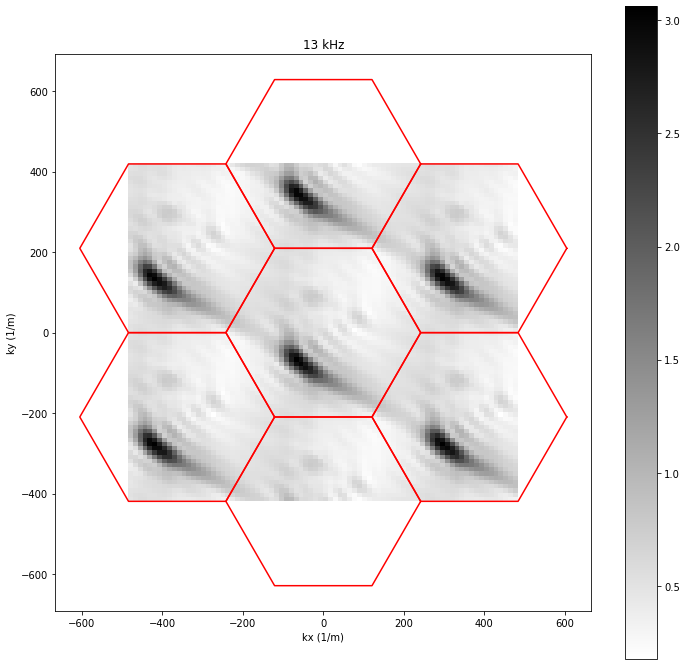

In [5]:
    
'''
Elements of real_data are assumed to look like:
    0: X in mm
    1: Y in mm
    2: Amplitude
    3: Phase in degrees

'''

x_unit = 10*np.sqrt(3)/4/1000
y_unit = 7.5/1000


for yi in tqdm(range(len(kys))):
    for xi in range(len(kxs)):
        for i in range(4):
            k_current=[kxs[xi] + G[i][0], kys[yi] + G[i][1]]
            raw = np.array(
                    [point[2] * np.exp(-1j * (k_current[0] * (point[0]*x_unit) + k_current[1] * (point[1]*y_unit) + (point[3] / 57.2957795131))) 
                        for point in real_data]).sum()
            amplitude = np.abs(raw)
            reciprocal_data[yi][xi] += amplitude
      

        

freq = 13
plt.figure(figsize=(12,12))
plt.imshow(reciprocal_data, cmap = 'binary', extent = [-2*kxmax, 2*kxmax, -2*kymax, 2*kymax], aspect = 'equal', origin = 'lower')

xBZ = np.zeros((7,7))
yBZ = np.zeros((7,7))

vec = np.array([[0,0], [np.sqrt(3), 1], [0, 2], [-np.sqrt(3),1], [-np.sqrt(3),-1], [0, -2], [np.sqrt(3),-1]])*kymax
xBZ[0] = [kxmax, 0.5*kxmax, -0.5*kxmax, -kxmax, -0.5*kxmax, 0.5*kxmax, kxmax]
yBZ[0] = [0, kymax, kymax, 0, -kymax, -kymax, 0]

for i in range(7):
    xBZ[i] = xBZ[0] + vec[i][0]
    yBZ[i] = yBZ[0] + vec[i][1]
    plt.plot(xBZ[i], yBZ[i], 'r-')


plt.xlabel("kx (1/m)")
plt.ylabel("ky (1/m)")
plt.title(str(freq)+" kHz")
plt.colorbar()

plt.savefig(folder + "fourier/figures/2D_DFT_{}kHz_NEW.png".format(freq))

100%|██████████| 100/100 [00:10<00:00,  9.97it/s]


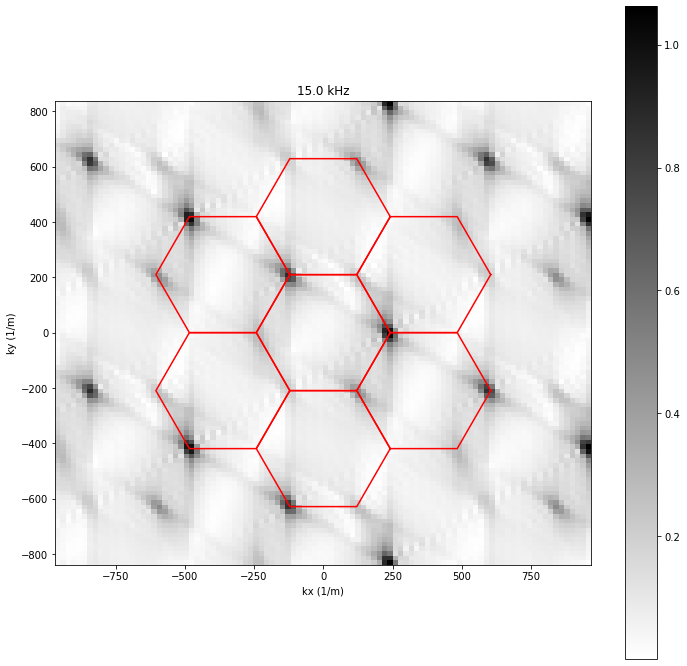

In [10]:
## 2D fourier transform - ORIGINAL!!!

from tqdm import tqdm

folder = "../../data/kagome-02.26.2022-center/"

with open(folder + "preprocessed_band/_8800.0_0.pkl",'rb') as f:
    real_data = pickle.load(f)



L_kag = 0.008
L = L_kag*np.sqrt(3)/2*(np.sqrt(3)+1)
L = 0.01

kxmax = 4*np.pi/(3*np.sqrt(3) * L)
kymax = 2*np.pi/(3*L)
kxs = np.linspace(-4*kxmax, 4*kxmax, 100)
kys = np.linspace(-4*kymax, 4*kymax, 100)


reciprocal_data = np.zeros((len(kxs), len(kys)))
reciprocal_raw = np.zeros((len(kxs), len(kys)), dtype=complex)

    
'''
Elements of real_data are assumed to look like:
    0: X in mm
    1: Y in mm
    2: Amplitude
    3: Phase in degrees

'''

x_unit = 0.01*np.sqrt(3)/4
y_unit = 0.01*3/4

for yi in tqdm(range(len(kys))):
    for xi in range(len(kxs)):
        raw = np.array(
                [point[2] * np.exp(-1j * (kxs[xi] * (point[0]*x_unit) + kys[yi] * (point[1]*y_unit) + (point[3] / 57.2957795131))) 
                    for point in real_data]).sum()
        amplitude = np.abs(raw)
        reciprocal_data[yi][xi] = amplitude
        reciprocal_raw[yi][xi] = raw
      

        

freq = 15.0
plt.figure(figsize=(12,12))
plt.imshow(reciprocal_data, cmap = 'binary', extent = [-4*kxmax, 4*kxmax, -4*kymax, 4*kymax], aspect = 'equal', origin = 'lower')

xBZ = np.zeros((7,7))
yBZ = np.zeros((7,7))

vec = np.array([[0,0], [np.sqrt(3), 1], [0, 2], [-np.sqrt(3),1], [-np.sqrt(3),-1], [0, -2], [np.sqrt(3),-1]])*kymax
xBZ[0] = [kxmax, 0.5*kxmax, -0.5*kxmax, -kxmax, -0.5*kxmax, 0.5*kxmax, kxmax]
yBZ[0] = [0, kymax, kymax, 0, -kymax, -kymax, 0]

for i in range(7):
    xBZ[i] = xBZ[0] + vec[i][0]
    yBZ[i] = yBZ[0] + vec[i][1]
    plt.plot(xBZ[i], yBZ[i], 'r-')


plt.xlabel("kx (1/m)")
plt.ylabel("ky (1/m)")
plt.title(str(freq)+" kHz")
plt.colorbar()

plt.savefig(folder + "fourier/figures/2D_DFT_{}kHz_ORIGINAL.png".format(freq))







[[0
  array([ 1000.,  1040.,  1080.,  1120.,  1160.,  1200.,  1240.,  1280.,
        1320.,  1360.,  1400.,  1440.,  1480.,  1520.,  1560.,  1600.,
        1640.,  1680.,  1720.,  1760.,  1800.,  1840.,  1880.,  1920.,
        1960.,  2000.,  2040.,  2080.,  2120.,  2160.,  2200.,  2240.,
        2280.,  2320.,  2360.,  2400.,  2440.,  2480.,  2520.,  2560.,
        2600.,  2640.,  2680.,  2720.,  2760.,  2800.,  2840.,  2880.,
        2920.,  2960.,  3000.,  3040.,  3080.,  3120.,  3160.,  3200.,
        3240.,  3280.,  3320.,  3360.,  3400.,  3440.,  3480.,  3520.,
        3560.,  3600.,  3640.,  3680.,  3720.,  3760.,  3800.,  3840.,
        3880.,  3920.,  3960.,  4000.,  4040.,  4080.,  4120.,  4160.,
        4200.,  4240.,  4280.,  4320.,  4360.,  4400.,  4440.,  4480.,
        4520.,  4560.,  4600.,  4640.,  4680.,  4720.,  4760.,  4800.,
        4840.,  4880.,  4920.,  4960.,  5000.,  5040.,  5080.,  5120.,
        5160.,  5200.,  5240.,  5280.,  5320.,  5360.,  5400.,  5440.,


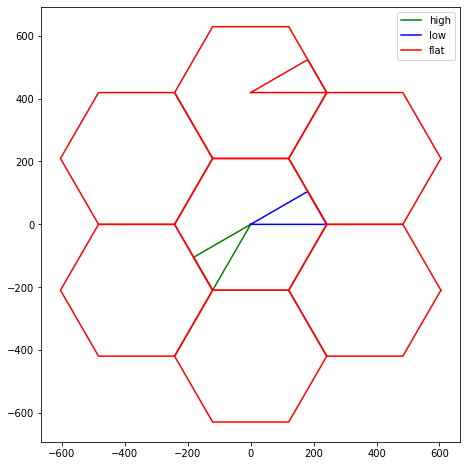

In [6]:
#GK'M'G sweeps

from tqdm import tqdm
import csv



#freqs = np.array([(0, np.array(list(np.linspace(1,16,76))+list(np.linspace(16,17, 51))+list(np.linspace(17,18,6))))], dtype=object)
freq_num = 426
freq_min = 1000.0
freq_max = 18000.0
freqs = np.array([(0, np.linspace(freq_min, freq_max, freq_num))], dtype=object)
print(freqs)

freq_div1 = 9000
freq_div2 = 130000

#L_kag = 0.008
#L = L_kag*np.sqrt(3)/2*(np.sqrt(3)+1)
L = 0.01
kxmax = 4*np.pi/(3*np.sqrt(3) * L)
kymax = 2*np.pi/(3*L)

b_res = 50
b = np.linspace(0, 1.5+np.sqrt(3)/2, b_res) #GKMG sweep parameter

kxb_low = np.zeros(len(b))
kyb_low = np.zeros(len(b))
kxb_high = np.zeros(len(b))
kyb_high = np.zeros(len(b))
kxb_flat = np.zeros(len(b))
kyb_flat = np.zeros(len(b))


for i in range(len(b)):
    if b[i] < 1:   
        
        #kxb_low[i] = b[i] * 2 * np.pi / (np.sqrt(3)*3 * L) 
        #kyb_low[i] = b[i] * 2 * np.pi / (3 * L)
        

        
        kxb_high[i] = -b[i] * 2 * np.pi / (np.sqrt(3)*3 * L) 
        kyb_high[i] = 4 * np.pi / (3 * L) - b[i] * 2 * np.pi / (3 * L)
        kxb_flat[i] = 4 * np.pi / (3 * np.sqrt(3) * L) * b[i]
        kyb_flat[i] = 4 * np.pi / (3 * L) 
        
        kxb_low[i] = kxb_flat[i]
        kyb_low[i] = kyb_flat[i] - 2*kymax
        
        kxb_high[i] = kxb_high[i]
        kyb_high[i] = kyb_high[i] - 2*kymax
        
    elif b[i] < 1.5: 
        #kxb_low[i] = 2 * np.pi / (np.sqrt(3)*3 * L) - 2 * 2 * np.pi / (3 * np.sqrt(3) * L) * (b[i]-1)
        #kyb_low[i] = 2 * np.pi / (3 * L) 
        kxb_high[i] = -2 * np.pi / (np.sqrt(3)*3 * L) + 2 * 2 * np.pi / (3 * np.sqrt(3) * L) * (b[i]-1)
        kyb_high[i] = 2 * np.pi / (3 * L) 
        kxb_flat[i] = 4 * np.pi / (3 * np.sqrt(3) * L) - 2 * np.pi / (3 * np.sqrt(3) * L) * (b[i]-1)
        kyb_flat[i] = 4 * np.pi / (3*L) + 2 * np.pi / (3 * L) * (b[i]-1)
        
        kxb_low[i] = kxb_flat[i] 
        kyb_low[i] = kyb_flat[i] - 2*kymax
        
        kxb_high[i] = kxb_low[i] - 1.5*kxmax
        kyb_high[i] = kyb_low[i] - kymax
    else:
        #kxb_low[i] = 0
        #kyb_low[i] = 2 * np.pi / (3 * L) - 2 * np.pi / (3 * L) *2 / np.sqrt(3) * (b[i]-1.5)
        kxb_high[i] = 0
        kyb_high[i] = 2 * np.pi / (3 * L) + 2 * np.pi / (3 * L) *2 / np.sqrt(3) * (b[i]-1.5)
        kxb_flat[i] = (1- (b[i] - 1.5) * 2 / np.sqrt(3)) * np.pi / (np.sqrt(3) * L)
        kyb_flat[i] = 4 * np.pi / (3*L) + (1- 2 / (np.sqrt(3)) * (b[i]-1.5)) * np.pi / (3 * L)
        
        kxb_low[i] = kxb_flat[i]
        kyb_low[i] = kyb_flat[i] - 2*kymax
        
        kxb_high[i] = -kxb_low[i] 
        kyb_high[i] = -kyb_low[i] 



plt.figure(figsize=(8,8))
#plt.plot(kxb_flat, kyb_flat, 'm-',label='flat')
plt.plot(kxb_high, kyb_high, 'g-',label='high')
plt.plot(kxb_low, kyb_low, 'b-',label='low')
plt.plot(kxb_flat, kyb_flat, 'r-',label='flat')
plt.legend()
ax = plt.gca()
ax.set_aspect('equal')

xBZ = np.zeros((7,7))
yBZ = np.zeros((7,7))

vec = np.array([[0,0], [np.sqrt(3), 1], [0, 2], [-np.sqrt(3),1], [-np.sqrt(3),-1], [0, -2], [np.sqrt(3),-1]])*kymax
xBZ[0] = [kxmax, 0.5*kxmax, -0.5*kxmax, -kxmax, -0.5*kxmax, 0.5*kxmax, kxmax]
yBZ[0] = [0, kymax, kymax, 0, -kymax, -kymax, 0]


for i in range(7):
    xBZ[i] = xBZ[0] + vec[i][0]
    yBZ[i] = yBZ[0] + vec[i][1]
    plt.plot(xBZ[i], yBZ[i], 'r-')


In [20]:
###Original

filename = '../../data/kagome-02.26.2022-center/preprocessed/'

reciprocal_data = np.zeros((freq_num, b_res))
x_unit = 10*np.sqrt(3)/4/1000
y_unit = 7.5/1000

    
for setno, values in freqs:
    for j in tqdm(range(len(values))):
        with open(filename + '_' + str(values[j]) + '_' + str(setno) + '.pkl','rb') as f:
            real_data = pickle.load(f)
            
            if values[j] <= freq_div1:
                
                for i in range(b_res):
                    amplitude = np.abs(np.array(
                            [point[2] * np.exp(1j * (kxb_low[i] * (point[0]*x_unit) + kyb_low[i] * (point[1]*y_unit) + (point[3] / 57.2957795131))) 
                                for point in real_data]).sum())
                    reciprocal_data[j][i] = amplitude
                    
            else:
                
                for i in range(b_res):
                    amplitude = np.abs(np.array(
                            [point[2] * np.exp(1j * (kxb_high[i] * (point[0]*x_unit) + kyb_high[i] * (point[1]*y_unit) + (point[3] / 57.2957795131))) 
                                for point in real_data]).sum())
                    reciprocal_data[j][i] = amplitude
'''          
            else:
                for i in range(b_res):
                    amplitude = np.abs(np.array(
                            [point[2] * np.exp(1j * (kxb_flat[i] * (point[0] / 1000) + kyb_flat[i] * (point[1] / 1000) + (point[3] / 57.2957795131))) 
                                for point in real_data]).sum())
                    reciprocal_data[j][i] = amplitude
'''   

            

100%|██████████| 426/426 [00:06<00:00, 64.79it/s]


'          \n            else:\n                for i in range(b_res):\n                    amplitude = np.abs(np.array(\n                            [point[2] * np.exp(1j * (kxb_flat[i] * (point[0] / 1000) + kyb_flat[i] * (point[1] / 1000) + (point[3] / 57.2957795131))) \n                                for point in real_data]).sum())\n                    reciprocal_data[j][i] = amplitude\n'

/Users/jiatongyang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "interpolation" which is no longer supported as of 3.3 and will become an error two minor releases later
/Users/jiatongyang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "interpolation" which is no longer supported as of 3.3 and will become an error two minor releases later


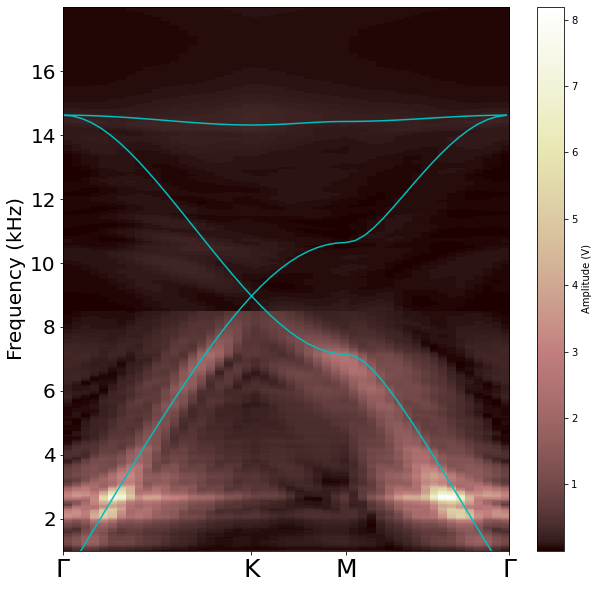

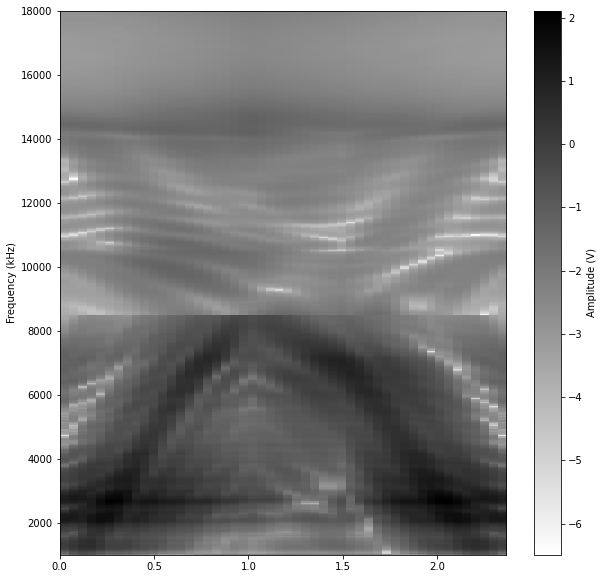

In [23]:
reciprocal_data_plot = np.zeros((freq_num, b_res))


for i in range(len(reciprocal_data)):
    reciprocal_data_plot[i] = reciprocal_data[i]#/np.average(reciprocal_data[i])
    #reciprocal_data_plot[i] = reciprocal_data[i]/reciprocal_data[i][0]
    #reciprocal_data_plot[i] = reciprocal_data[i]/reciprocal_data[i].max()



folder = '../../data/kagome-02.26.2022-center/'

b_sim = []
band1 = []
band2 = []
band3 = []

with open('../../data/simulation/kagome_machine_bands_clean.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    
    for row in reader:
        b_sim.append(float(row[0]))
        band1.append(float(row[1]))
        band2.append(float(row[2]))
        band3.append(float(row[3]))


    
# GKMG sweep
plt.figure(figsize = (10, 10))
color_map = plt.cm.get_cmap('pink')
reversed_magma = color_map.reversed()
plt.imshow(reciprocal_data_plot, cmap = 'pink', extent = [b[0], b[-1], freq_min/1000, freq_max/1000], aspect = 'auto', origin = 'lower', interpolation='none')
plt.plot(b_sim, band1, 'c-')
plt.plot(b_sim, band2, 'c-')
plt.plot(b_sim, band3, 'c-')
plt.colorbar(label = 'Amplitude (V)')
plt.ylabel("Frequency (kHz)", fontsize = 20)
plt.axis([b[0], b[-1], freq_min/1000, freq_max/1000])
plt.yticks(np.linspace(2, 16, 8), fontsize = 20)
plt.xticks([0, 1, 1.5, b[-1]], ['\u0393', 'K', 'M', '\u0393'], fontsize=25)
plt.savefig(folder + "fourier/figures/GK'M'G_sweep2_ORIGINAL", interpolation='none')


plt.figure(figsize = (10, 10))
plt.imshow(np.log(reciprocal_data_plot), cmap = 'binary', extent = [b[0], b[-1], freq_min, freq_max], aspect = 'auto', origin = 'lower', interpolation='none')
plt.colorbar(label = 'Amplitude (V)')
plt.plot(b_sim, band1, 'y-')
plt.plot(b_sim, band2, 'y-')
plt.plot(b_sim, band3, 'y-')
plt.ylabel("Frequency (kHz)")
plt.axis([b[0], b[-1], freq_min, freq_max])
plt.savefig(folder + "fourier/figures/GK'M'G_sweep2_binary_ORIGINAL", interpolation='none')

In [7]:
###New

filename = '../../data/kagome-02.26.2022-center/preprocessed_band/'

reciprocal_data = np.zeros((freq_num, b_res))
x_unit = 10*np.sqrt(3)/4/1000
y_unit = 7.5/1000

G = [[0.0, 0.0], [6*np.pi/(3*np.sqrt(3) * L), 2*np.pi/(3*L)], [6*np.pi/(3*np.sqrt(3) * L), -2*np.pi/(3*L)], [0, 4*np.pi/(3*L)]]
    
for setno, values in freqs:
    for j in tqdm(range(len(values))):
        with open(filename + '_' + str(values[j]) + '_' + str(setno) + '.pkl','rb') as f:
            real_data = pickle.load(f) 
            
            if values[j] <= freq_div1:
                
                for i in range(b_res):
                    for k_no in range(4):
                        k_current = [kxb_low[i] + G[k_no][0], kyb_low[i] + G[k_no][1]]
                        amplitude = np.abs(np.array(
                                [point[2] * np.exp(1j * (k_current[0] * (point[0]*x_unit) + k_current[1] * (point[1]*y_unit) + (point[3] / 57.2957795131))) 
                                    for point in real_data]).sum())
                        reciprocal_data[j][i] += amplitude
                        
            else:
                for i in range(b_res):
                    for k_no in range(4):
                        k_current = [kxb_high[i] + G[k_no][0], kyb_high[i] + G[k_no][1]]
                        amplitude = np.abs(np.array(
                                [point[2] * np.exp(1j * (k_current[0] * (point[0]*x_unit) + k_current[1] * (point[1]*y_unit) + (point[3] / 57.2957795131))) 
                                    for point in real_data]).sum())
                        reciprocal_data[j][i] += amplitude
 

            

reciprocal_data_plot = np.zeros((freq_num, b_res))


for i in range(len(reciprocal_data)):
    reciprocal_data_plot[i] = reciprocal_data[i]

100%|██████████| 426/426 [01:27<00:00,  4.85it/s]


In [8]:
#print(np.max(reciprocal_data_plot))

#reciprocal_data_plot = (reciprocal_data-np.min(reciprocal_data))/(np.max(reciprocal_data)-reciprocal_data)
reciprocal_data_plot = reciprocal_data/np.max(reciprocal_data)

/Users/jiatongyang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "interpolation" which is no longer supported as of 3.3 and will become an error two minor releases later
/Users/jiatongyang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:86: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "interpolation" which is no longer supported as of 3.3 and will become an error two minor releases later


'\nplt.figure(figsize = (10, 10))\n#plt.imshow(reciprocal_data_plot[np.linspace(1,76,76).astype(int)], cmap = \'binary\', extent = [b[0], b[-1], 1, 16], aspect = \'auto\', origin = \'lower\', interpolation=\'none\')\n#plt.imshow(reciprocal_data_plot[np.linspace(77,77+51,51).astype(int)], cmap = \'binary\', extent = [b[0], b[-1], 16, 17], aspect = \'auto\', origin = \'lower\', interpolation=\'none\')\n#plt.imshow(reciprocal_data_plot[np.linspace(77+51,77+51+6,6).astype(int)], cmap = \'binary\', extent = [b[0], b[-1], 17, 18], aspect = \'auto\', origin = \'lower\', interpolation=\'none\')\nplt.imshow(reciprocal_data_plot, cmap = \'binary\', extent = [b[0], b[-1], 1, 18], aspect = \'auto\', origin = \'lower\', interpolation=\'none\')\nplt.colorbar(label = \'Amplitude (V)\')\nplt.plot(b_sim, band1, \'y-\')\nplt.plot(b_sim, band2, \'y-\')\nplt.plot(b_sim, band3, \'y-\')\nplt.ylabel("Frequency (kHz)")\nplt.axis([b[0], b[-1], 1, 18])\nplt.savefig(folder + "fourier/figures/GK\'M\'G_sweep2_bina

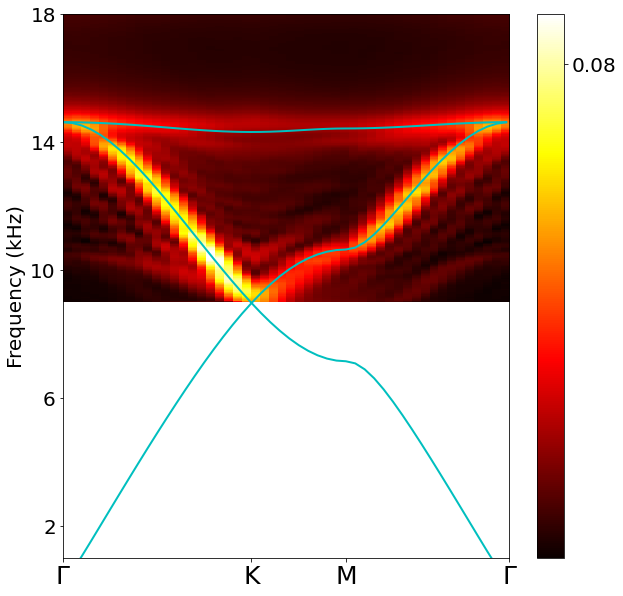

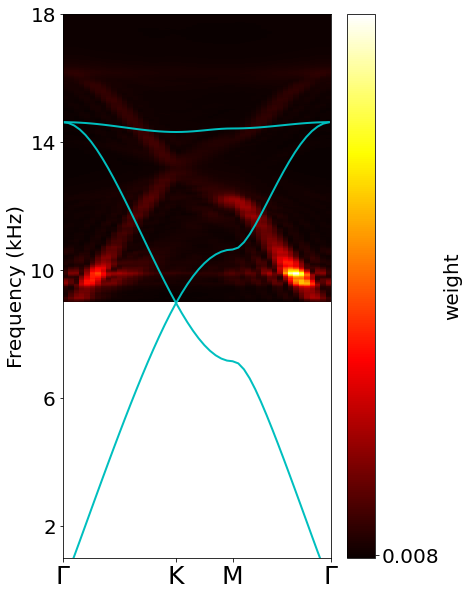

In [9]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.colors as colors
import matplotlib.cm as cm


folder = '../../data/kagome-02.26.2022-center/'

b_sim = []
band1 = []
band2 = []
band3 = []


with open('../../data/simulation/kagome_machine_bands_clean.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    
    for row in reader:
        b_sim.append(float(row[0]))
        band1.append(float(row[1]))
        band2.append(float(row[2]))
        band3.append(float(row[3]))

        
hot = cm.get_cmap('hot', 256)
hotnew = hot(np.linspace(0, 1, 256))
white = np.array([1, 1, 1, 1])
hotnew[63:, :] = white
hotnew[:63, :] = hot(np.linspace(0, 1, 63))
newcmp = ListedColormap(hotnew)

  



# GKMG sweep
plt.figure(figsize = (10, 10))
color_map = plt.cm.get_cmap('gist_heat')
reversed_magma = color_map.reversed()
freq = np.linspace(1000.0, 18000.0, 426)
min_index = np.where(freq == 9000.0)[0][0]
max_index = len(reciprocal_data)
#plt.imshow(reciprocal_data_plot[np.linspace(1,76,76).astype(int)], cmap = 'pink', extent = [b[0], b[-1], 1, 16], aspect = 'auto', origin = 'lower', interpolation='none')
#plt.imshow(reciprocal_data_plot[np.linspace(77,77+50,51).astype(int)], cmap = 'pink', extent = [b[0], b[-1], 16, 17], aspect = 'auto', origin = 'lower', interpolation='none')
#plt.imshow(reciprocal_data_plot[np.linspace(77+51,77+51+5,6).astype(int)], cmap = 'pink', extent = [b[0], b[-1], 17, 18], aspect = 'auto', origin = 'lower', interpolation='none')
#plt.imshow(reciprocal_data_plot[np.linspace(1,550,550).astype(int)], cmap = 'pink', extent = [b[0], b[-1], freq_min/1000, freq_max/1000], aspect = 'auto', origin = 'lower', interpolation='none')
plt.imshow(reciprocal_data_plot[np.linspace(min_index, max_index-1,max_index-min_index-1).astype(int)], cmap = hot, extent = [b[0], b[-1], 9.0, freq_max/1000], aspect = 'auto', origin = 'lower', interpolation='none')
plt.plot(b_sim, band1, linestyle = '-', color = "c", linewidth = 2)
plt.plot(b_sim, band2, linestyle = '-', color = "c", linewidth = 2)
plt.plot(b_sim, band3, linestyle = '-', color = "c", linewidth = 2)
plt.axis([b[0], b[-1], 1, 18])
#plt.colorbar(label = 'Amplitude (V)')
cb = plt.colorbar()
#cb.set_label(label='weight',size=20)
cb.set_ticks(np.linspace(0,0.08,2))
cb.ax.tick_params(labelsize=20)
plt.ylabel("Frequency (kHz)", fontsize = 20)
plt.yticks(np.linspace(2, 18, 5), fontsize = 20)
plt.xticks([0, 1, 1.5, b[-1]], ['\u0393', 'K', 'M', '\u0393'], fontsize=25)
plt.savefig(folder + "fourier/figures/GK'M'G_sweep2_NEW", interpolation='none')


plt.figure(figsize = (6, 10))
color_map = plt.cm.get_cmap('gist_heat')
reversed_magma = color_map.reversed()
freq = np.linspace(9000.0, 18000.0, 426)
min_index = np.where(freq == 9000.0)[0][0]
max_index = len(reciprocal_data)
#plt.imshow(reciprocal_data_plot[np.linspace(1,76,76).astype(int)], cmap = 'pink', extent = [b[0], b[-1], 1, 16], aspect = 'auto', origin = 'lower', interpolation='none')
#plt.imshow(reciprocal_data_plot[np.linspace(77,77+50,51).astype(int)], cmap = 'pink', extent = [b[0], b[-1], 16, 17], aspect = 'auto', origin = 'lower', interpolation='none')
#plt.imshow(reciprocal_data_plot[np.linspace(77+51,77+51+5,6).astype(int)], cmap = 'pink', extent = [b[0], b[-1], 17, 18], aspect = 'auto', origin = 'lower', interpolation='none')
#plt.imshow(reciprocal_data_plot[np.linspace(1,550,550).astype(int)], cmap = 'pink', extent = [b[0], b[-1], freq_min/1000, freq_max/1000], aspect = 'auto', origin = 'lower', interpolation='none')
plt.imshow(reciprocal_data_plot[np.linspace(min_index, max_index-1,max_index-min_index-1).astype(int)], cmap = 'hot', extent = [b[0], b[-1], 9.0, freq_max/1000], aspect = 'auto', origin = 'lower', interpolation='none')
plt.plot(b_sim, band1, linestyle = '-', color = "c", linewidth = 2)
plt.plot(b_sim, band2, linestyle = '-', color = "c", linewidth = 2)
plt.plot(b_sim, band3, linestyle = '-', color = "c", linewidth = 2)
plt.axis([b[0], b[-1], 1, 18])
#plt.colorbar(label = 'Amplitude (V)')
cb = plt.colorbar()
cb.set_label(label='weight',size=20)
cb.set_ticks(np.linspace(0,0.008,2))
cb.ax.tick_params(labelsize=20)
plt.ylabel("Frequency (kHz)", fontsize = 20)
plt.yticks(np.linspace(2, 18, 5), fontsize = 20)
plt.xticks([0, 1, 1.5, b[-1]], ['\u0393', 'K', 'M', '\u0393'], fontsize=25)
plt.savefig(folder + "fourier/figures/GK'M'G_sweep2_NEW_thin", interpolation='none')



'''
plt.figure(figsize = (10, 10))
#plt.imshow(reciprocal_data_plot[np.linspace(1,76,76).astype(int)], cmap = 'binary', extent = [b[0], b[-1], 1, 16], aspect = 'auto', origin = 'lower', interpolation='none')
#plt.imshow(reciprocal_data_plot[np.linspace(77,77+51,51).astype(int)], cmap = 'binary', extent = [b[0], b[-1], 16, 17], aspect = 'auto', origin = 'lower', interpolation='none')
#plt.imshow(reciprocal_data_plot[np.linspace(77+51,77+51+6,6).astype(int)], cmap = 'binary', extent = [b[0], b[-1], 17, 18], aspect = 'auto', origin = 'lower', interpolation='none')
plt.imshow(reciprocal_data_plot, cmap = 'binary', extent = [b[0], b[-1], 1, 18], aspect = 'auto', origin = 'lower', interpolation='none')
plt.colorbar(label = 'Amplitude (V)')
plt.plot(b_sim, band1, 'y-')
plt.plot(b_sim, band2, 'y-')
plt.plot(b_sim, band3, 'y-')
plt.ylabel("Frequency (kHz)")
plt.axis([b[0], b[-1], 1, 18])
plt.savefig(folder + "fourier/figures/GK'M'G_sweep2_binary_NEW")
'''

In [41]:
# Find peaks in the band structure and scatter them

from scipy.signal import find_peaks

peaks = []
peak_count = 2

freqs = np.linspace(freq_min, freq_max, freq_num)

scatterX = []
scatterY = []

folder = '../../data/sim_kagome25_central_triangle/'

for i in range(550): #214-428: 12-18 kHZ
    
    def peakValue(index):
        return reciprocal_data[i][index]

    peak_indices, _ = find_peaks(reciprocal_data[i])
    peak_indices = list(peak_indices)
    peak_indices.sort(key = peakValue, reverse = True)
    
    for j in range(peak_count):
        scatterX.append(b[peak_indices[j]])
        scatterY.append(freqs[i])

plt.figure(figsize=(8,10))
plt.plot(b_sim, np.array(band1), 'r-')
plt.plot(b_sim, np.array(band2), 'r-')
plt.plot(b_sim, np.array(band3), 'r-')
plt.scatter(scatterX, np.array(scatterY), 10)
plt.ylabel("Frequency (kHz)", fontsize = 20)
plt.axis([b[0], b[-1], freq_min/1000, freq_max/1000])
plt.yticks(np.linspace(2, 16, 8), fontsize = 20)
plt.yticks(np.linspace(2, 16, 8), fontsize = 20)
plt.xticks([0, 1, 1.5, b[-1]], ['\u0393', 'K', 'M', '\u0393'], fontsize=25)
plt.grid()
plt.savefig(folder + "fourier/figures/GKMG_sweep2_peaks_2_new" + str(peak_count))

# GKMG sweep




        
print(folder)

IndexError: list index out of range

0.318056


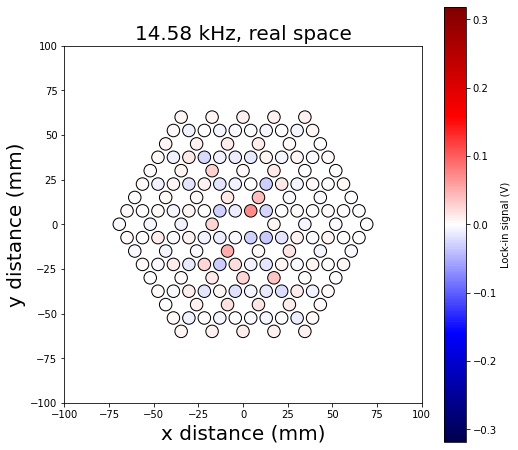

In [2]:
# Animating chirp scans

from matplotlib import patches as ptc
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.cm as cm
import matplotlib.colors as colors


kagome_lattice = [((-0.8660,  0.0000), 0.35),
                ((-0.4330,  0.750), 0.35),
                (( 0.4330,  0.750), 0.35),
                (( 0.8660,  0.0000), 0.35),
                (( 0.4330, -0.750), 0.35),
                ((-0.4330, -0.750), 0.35)]


folder = "../../data/kagome-02.26.2022-center/"

with open(folder + "preprocessed_real/_14560.0_0.pkl",'rb') as f:
    real_data = pickle.load(f)    
    

lattice_offset = kagome_lattice[4][0]
unit_cell = 10.0
radius = kagome_lattice[0][1]*unit_cell

amp = real_data[:, 2]
amp = amp.tolist()
max_amp = max(amp)
#max_amp = 1.0

freq = 14.58
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_aspect("equal")
ax.set_xlim(-100, 100)
ax.set_ylim(-100, 100)
ax.set_xlabel("x distance (mm)", fontsize=20)
ax.set_ylabel("y distance (mm)", fontsize=20)
ax.set_title(str(freq) + " kHz, real space", fontsize=20)
cbar = fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin=-max_amp, vmax=max_amp), cmap = "seismic"), ax=ax, label="Lock-in signal (V)")

cavities = []
ampdata = []
phasedata = []
t = 0
dt = 0.1

x_unit = 10*np.sqrt(3)/4
y_unit = 7.5

for point in real_data:
    x_center = point[0]*x_unit
    y_center = point[1]*y_unit
    
    if (y_center == 12 * 7.5) and (x_center > 75) and (x_center < 90):
        print("transducer 1 phase: " + str(point[3]))
    
    if (y_center == 12 * 7.5) and (x_center > 90) and (x_center < 105):
        print("transducer 2 phase: " + str(point[3]))
    
    #ampdata.append(np.sqrt(point[2])*np.sqrt(max_amp))
    ampdata.append(point[2])
    phasedata.append(point[3])
    

    
    pressure = ampdata[-1]*np.sin(np.deg2rad(phasedata[-1]))
    #pressure = np.sin(np.deg2rad(phasedata[-1]))

    circle = ptc.Ellipse((x_center, y_center), 
                     width = radius*2, 
                     height = radius*2, 
                     edgecolor='black', facecolor = plt.cm.seismic((pressure+max_amp)/(2.0*max_amp)),
                     fill = True, alpha = 1)
    cavities.append(circle)
    ax.add_patch(cavities[-1])
    
def init():
    """initialize animation"""
    global cavities, t
    
    t = 0
    
    for i in range(len(cavities)):
        pressure = ampdata[i]*np.sin(np.deg2rad(phasedata[i])+t)
        #pressure = np.sin(np.deg2rad(phasedata[i]) + t)
        
        cavities[i].set_facecolor(plt.cm.seismic((pressure+max_amp)/(2.0*max_amp)))
                             
    return cavities
    
def animate(j):
    global t, dt, cavities, ampdata, phasedata
    t += dt
                            
    for i in range(len(cavities)):
        pressure = ampdata[i]*np.sin(np.deg2rad(phasedata[i]+j))
        #pressure = np.sin(np.deg2rad(phasedata[i]) + j)
        cavities[i].set_facecolor(plt.cm.seismic((pressure+max_amp)/(2.0*max_amp)))
                             
    return cavities

ani = animation.FuncAnimation(fig, animate, frames = 360, interval = 20, blit = True, init_func = init)
print(max_amp)

In [19]:
ani.save(folder + 'animations/' + str(freq) + 'kHz.gif', writer = 'imagemagick', fps = 60)

[0.09094364 0.07030373 0.08707373 0.1115827  0.25864031 0.07094876
 0.03353938 0.21413658 0.13222303 0.09287854 0.03353938 0.04772924
 0.03934429 0.0883637  0.05417908 0.0773986  0.12770756 0.01676969
 0.00902984 0.0902986  0.10384332 0.05095421 2.3464693  0.72496895
 0.3128196  0.1135176  2.29551308 0.18253252 0.28250477 0.11480788
 0.88041077 0.11996797 0.95393905 0.32894341 1.63569243 0.73012903
 0.27799036 0.05998398 2.08718649 0.90749936 0.11287299 0.17543754
 0.38699355 0.11545356 1.69438402 0.43278757 0.15221769 0.45665203
 0.52050581 0.35216431 0.03031451 0.29669474 0.48245139 0.28895514
 0.02902454 0.6314439  0.13028813 0.2483212  0.2051067  0.61531903
 0.0432144  0.18253252 0.1502828  0.55017497 0.1954322  0.15157202
 0.13544716 0.06836883 0.06901376 0.58177902 0.06320896 0.10319828
 0.16963284 0.07675357 0.10061834 0.05288911 0.28379506 0.21413658
 0.19220702 0.05159914 0.24509602 0.16576304 0.52437561 0.18640232
 0.13415793 0.0941685  0.13544716 0.06191888 0.09481354 0.1335

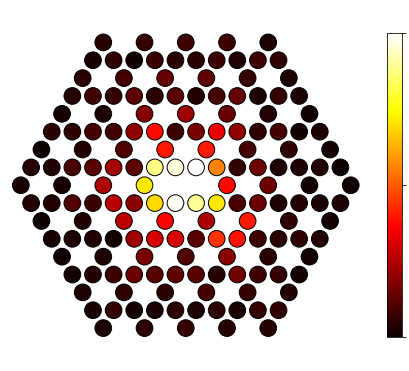

In [9]:
# Amplitude plot


from matplotlib import patches as ptc
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm

freq = 14.2

folder = "../../data/kagome-02.26.2022-center/"
with open(folder + f"preprocessed_real/_{int(freq*1e3)}.0_0.pkl",'rb') as f:
    real_data = pickle.load(f) 
    
preamp_gain = 4.731513 
mic_gain = 0.02 #0.02V/Pa 

cavities = []
ampdata = []
phasedata = []

amp = real_data[:, 2]
amp = amp/preamp_gain/mic_gain
print(amp)
amp = amp.tolist()
max_amp = max(amp)
print(max_amp)
print(min(amp))

fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_aspect("equal")
ax.set_xlim(-75, 75)
ax.set_ylim(-75, 75)
ax.axis('off')
#ax.set_xlabel("x distance (mm)")
#ax.set_ylabel("y distance (mm)")
plt.yticks([])
plt.xticks([])
cbar = fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin=0, vmax=max_amp), cmap = "hot"), ax=ax, shrink=0.7)
#cbar.set_label(label='Amplitude (V)',size=20)

cbar.ax.tick_params(labelsize=15)

ampdata = []
phasedata = []
radius = 3.5
    
x_unit = 10*np.sqrt(3)/4
y_unit = 7.5

for point in real_data:
    x_center = point[0]*x_unit
    y_center = point[1]*y_unit
    
    ampdata.append(point[2]/preamp_gain/mic_gain)
    phasedata.append(point[3])
    
    
    circle = ptc.Ellipse((x_center, y_center), 
                     width = radius*2, 
                     height = radius*2, 
                     edgecolor='black', facecolor = plt.cm.hot(ampdata[-1]/max_amp),
                     fill = True, alpha = 1)
    cavities.append(circle)
    ax.add_patch(cavities[-1])

cbar.set_ticks(np.linspace(0, np.max(ampdata), 3))
cbar.ax.set_yticklabels(['','',''])
plt.savefig(folder + f"animations/amplitude_plot_{freq}kHz_horizontal.png")

In [17]:
from IPython.display import HTML, Image

Image(url = folder + 'animations/' + str(freq) + 'kHz_sqrt.gif')

'\nplt.figure(figsize=(20,10))\nplt.plot(freq/1000, amplitude/normFactor, \'b-\')\nplt.axis([4, 20, 0, max(amplitude/normFactor)])\nplt.xlabel("frequency (kHz)")\nplt.ylabel("response amplitude (V)")\nplt.xticks(np.linspace(0, 20, 21))\nplt.grid()\n\n\nplt.figure()\nplt.plot(freq, phase, \'b-\')\n#plt.axis([0, 20000, 0, 0.25])\nplt.xlabel("frequency (Hz)")\nplt.ylabel("response amplitude (V)")\nplt.grid()\nplt.savefig("../../data/kagome-01.15.2022-1transducer/figures/1_-1_phase.png")\n'

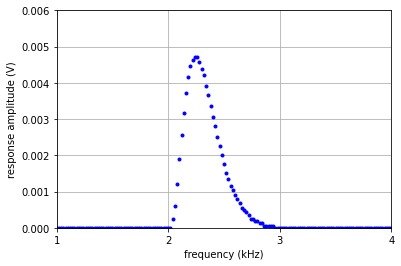

In [4]:
import matplotlib.pyplot as plt
import pickle
import numpy as np


with open('../../data/jiatong-transducerTest/raw/2kHz.pkl', 'rb') as f:
    data = pickle.load(f)

'''
with open('../../data/kagome-01.15.2022-1transducer/data/noMetamaterial3.pkl', 'rb') as f:
    ref = pickle.load(f)
'''

freq = data[:,0]
amplitude = data[:,1]
phase = data[:,2]


#normFactor = ref[:,1]



plt.figure(figsize=(20,10))
plt.plot(freq/1000, amplitude, 'b.')

plt.xlabel("frequency (kHz)")
plt.ylabel("response amplitude (V)")
plt.xticks(np.linspace(0, 20, 21))
plt.axis([1, 4, 0, 0.006])
plt.grid()
plt.savefig("../../data/jiatong-transducerTest/response/2kHz.png")

'''
plt.figure(figsize=(20,10))
plt.plot(freq/1000, amplitude/normFactor, 'b-')
plt.axis([4, 20, 0, max(amplitude/normFactor)])
plt.xlabel("frequency (kHz)")
plt.ylabel("response amplitude (V)")
plt.xticks(np.linspace(0, 20, 21))
plt.grid()


plt.figure()
plt.plot(freq, phase, 'b-')
#plt.axis([0, 20000, 0, 0.25])
plt.xlabel("frequency (Hz)")
plt.ylabel("response amplitude (V)")
plt.grid()
plt.savefig("../../data/kagome-01.15.2022-1transducer/figures/1_-1_phase.png")
'''

In [22]:
## STEP 1: PREPROCESS DATA
proc.preprocess_chirp(data_dir = '../../data/kagome-02.26.2022-center/raw/real_space/', 
                       frequencies = np.linspace(1000, 18000, 426), 
                       targetfile = '../../data/kagome-02.26.2022-center/preprocessed/', 
                       title = 'scppos_', setno = 0)

Found 25 records
Preprocessing complete!


0.361269


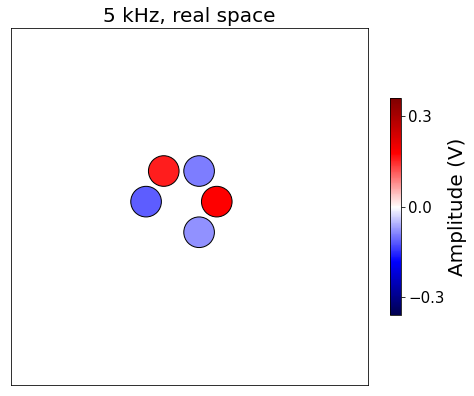

In [37]:
# Animating chirp scans

from matplotlib import patches as ptc
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.cm as cm
import matplotlib.colors as colors


kagome_lattice = [((-0.8660,  0.0000), 0.35),
                ((-0.4330,  0.750), 0.35),
                (( 0.4330,  0.750), 0.35),
                (( 0.8660,  0.0000), 0.35),
                (( 0.4330, -0.750), 0.35),
                ((-0.4330, -0.750), 0.35)]


folder = "../../data/extkag-03.08.2022/"

with open(folder + "preprocessed/_14320.0_0.pkl",'rb') as f:
    real_data = pickle.load(f)    
    

lattice_offset = kagome_lattice[4][0]
unit_cell = 10.0
radius = kagome_lattice[0][1]*unit_cell
radius = 3

amp = real_data[:, 2]
amp = amp.tolist()
max_amp = max(amp)
#max_amp = 1.0

freq = 5
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_aspect("equal")
ax.set_xlim(-30, 40)
ax.set_ylim(-30, 40)
#ax.set_xlabel("x distance (mm)", fontsize=20)
#ax.set_ylabel("y distance (mm)", fontsize=20)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title(str(freq) + " kHz, real space", fontsize=20)
cbar = fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin=-max_amp, vmax=max_amp), cmap = "seismic"), ax=ax, label="Lock-in signal (V)", shrink = 0.5)
cbar.set_label(label='Amplitude (V)',size=20)
cbar.set_ticks(np.linspace(-0.3, 0.3, 3))
cbar.ax.tick_params(labelsize=15)

cavities = []
ampdata = []
phasedata = []
t = 0
dt = 0.1

for point in real_data:
    x_center = point[0]
    y_center = point[1]
    
    if (y_center == 12 * 7.5) and (x_center > 75) and (x_center < 90):
        print("transducer 1 phase: " + str(point[3]))
    
    if (y_center == 12 * 7.5) and (x_center > 90) and (x_center < 105):
        print("transducer 2 phase: " + str(point[3]))
    
    
    ampdata.append(point[2])
    #ampdata.append(np.sqrt(point[2])*np.sqrt(max_amp))
    phasedata.append(point[3])
    

    
    pressure = ampdata[-1]*np.sin(np.deg2rad(phasedata[-1]))
    #pressure = np.sin(np.deg2rad(phasedata[-1]))

    circle = ptc.Ellipse((x_center, y_center), 
                     width = radius*2, 
                     height = radius*2, 
                     edgecolor='black', facecolor = plt.cm.seismic((pressure+max_amp)/(2.0*max_amp)),
                     fill = True, alpha = 1)
    cavities.append(circle)
    ax.add_patch(cavities[-1])
    
def init():
    """initialize animation"""
    global cavities, t
    
    t = 0
    
    for i in range(len(cavities)):
        pressure = ampdata[i]*np.sin(np.deg2rad(phasedata[i])+t)
        #pressure = np.sin(np.deg2rad(phasedata[i]) + t)
        
        cavities[i].set_facecolor(plt.cm.seismic((pressure+max_amp)/(2.0*max_amp)))
                             
    return cavities
    
def animate(j):
    global t, dt, cavities, ampdata, phasedata
    t += dt
                            
    for i in range(len(cavities)):
        pressure = ampdata[i]*np.sin(np.deg2rad(phasedata[i]+j))
        #pressure = np.sin(np.deg2rad(phasedata[i]) + j)
        cavities[i].set_facecolor(plt.cm.seismic((pressure+max_amp)/(2.0*max_amp)))
                             
    return cavities

ani = animation.FuncAnimation(fig, animate, frames = 360, interval = 1, blit = True, init_func = init)
print(max_amp)

In [36]:
## STEP 1: PREPROCESS DATA
proc.preprocess_chirp(data_dir = '../../data/extkag-03.08.2022/raw/avg-response/', 
                       frequencies = np.linspace(5000.0, 17000.0, 301), 
                       targetfile = '../../data/extkag-03.08.2022/preprocessed/', 
                       title = 'scppos_', setno = 0)

Found 5 records
Preprocessing complete!


In [51]:
ani.save(folder + 'animations/' + '5kHz.gif', writer = 'Pillow', fps = 720)

MovieWriter Pillow unavailable; using Pillow instead.


In [17]:
from IPython.display import HTML, Image

Image(url = folder + 'animations/' + str(freq) + '14.56kHz.gif')

59
300
301


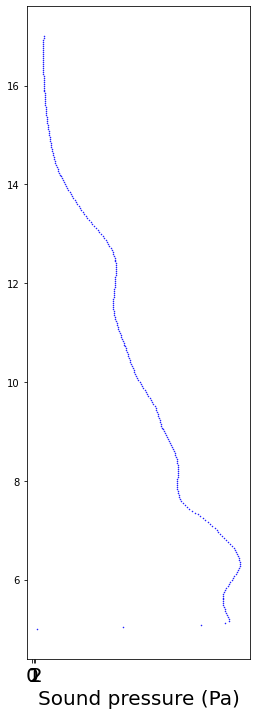

In [42]:
import matplotlib.pyplot as plt
import pickle
import numpy as np

from os import listdir
from os.path import isfile, join
mypath = '../../data/extkag-03.08.2022/raw/real-space'
onlyfiles = [f for f in listdir(mypath) if (isfile(join(mypath, f)) and f != '.DS_Store')]

print(len(onlyfiles))
amplitude = np.array(np.zeros(301))
for file in onlyfiles:
    with open(join(mypath, file), 'rb') as f:
        data = pickle.load(f)
        freq = data[:,0]
        amplitude += data[:,1]/np.mean([data[:,1]])
        
amplitude = amplitude/11

preamp_gain = 4.731513 
mic_gain = 0.02 #0.02V/Pa 

amplitude = amplitude/preamp_gain/mic_gain


min_index = np.where(freq == 5000.0)[0][0]
max_index = np.where(freq == 17000.0)[0][0]
print(max_index)
num = max_index-min_index+1
print(num)
plt.figure(figsize=(4,12))
plt.plot(amplitude[np.linspace(min_index,max_index,num).astype(int)],freq[np.linspace(min_index,max_index,num).astype(int)]/1000, 'b.', markersize = 1)
#plt.axis([0, 4, 1, 18])
#plt.ylabel("frequency (kHz)", fontsize = 20)
plt.xlabel("Sound pressure (Pa)", fontsize = 20)
plt.xticks(np.linspace(0, 2, 3), fontsize = 20)
#plt.yticks([])
#plt.grid()
plt.savefig("../../data/extkag-03.08.2022/response/avg_amp.png")



425
251


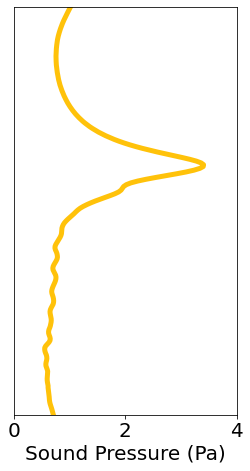

In [1]:
import matplotlib.pyplot as plt
import pickle
import numpy as np

from os import listdir
from os.path import isfile, join
mypath = '../../data/kagome-02.26.2022-center/raw/real_space/scppos_1_1.pkl'


amplitude = np.zeros(426)
with open(mypath, 'rb') as f:
    data = pickle.load(f)
    freq = data[:,0]
    amplitude = data[:,1]
    
        
preamp_gain = 4.731513 
mic_gain = 0.02 #0.02V/Pa 
amplitude = amplitude/preamp_gain/mic_gain
min_index = np.where(freq == 8000.0)[0][0]
max_index = np.where(freq == 18000.0)[0][0]
print(max_index)
num = max_index-min_index+1
print(num)
plt.figure(figsize=(4,7.5))
plt.plot(amplitude[np.linspace(min_index,max_index,num).astype(int)],freq[np.linspace(min_index,max_index,num).astype(int)]/1000, color = '#FFC20A', linestyle = '-', linewidth = 5)
plt.axis([0, 4, 9, 18])
#plt.ylabel("frequency (kHz)", fontsize = 20)
plt.xlabel("Sound Pressure (Pa)", fontsize = 20)
plt.xticks(np.linspace(0, 4, 3), fontsize = 20)
plt.yticks([])
#plt.grid()
plt.savefig("../../data/kagome-02.26.2022-center/response/1_amp.png")



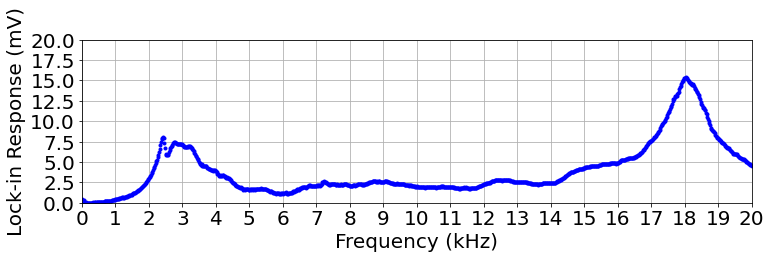

In [31]:
import matplotlib.pyplot as plt
import pickle
import numpy as np

from os import listdir
from os.path import isfile, join
mypath = '../../data/qFactorTest/raw/0-20kHz-1001pts.pkl'


amplitude = np.zeros(1251)
with open(mypath, 'rb') as f:
    data = pickle.load(f)
    freq = data[:,0]
    amplitude = data[:,1]

with open('../../data/qFactorTest/raw/0-20kHz-1001pts_openAir2.pkl', 'rb') as f:
    data = pickle.load(f)
    freq = data[:,0]
    reference = data[:,1]

    
plt.figure(figsize=(12,3))
plt.plot(freq/1000, reference*1000, 'b.')
plt.axis([1, 20, 0,20])
plt.xlabel("Frequency (kHz)", fontsize = 20)
plt.ylabel("Lock-in Response (mV)", fontsize = 20)
plt.xticks(np.linspace(0, 20, 21), fontsize = 20)
plt.yticks(fontsize = 20)
plt.grid()
plt.savefig("../../data/qFactorTest/response/normalized.png")



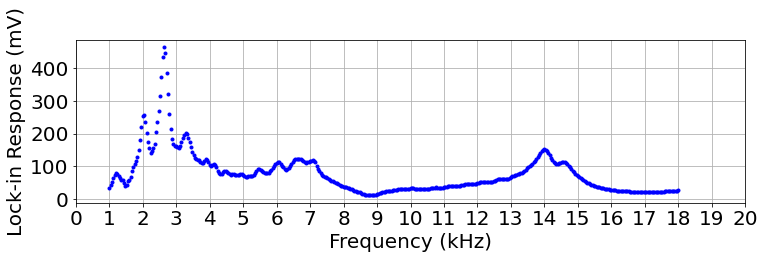

In [16]:
import matplotlib.pyplot as plt
import pickle
import numpy as np

from os import listdir
from os.path import isfile, join
filepath = '../../data/kagome-02.26.2022-center/raw/band_structure/scppos_3_1.pkl'


with open(filepath, 'rb') as f:
    data = pickle.load(f)
    freq = data[:,0]
    response = data[:,1]

    
plt.figure(figsize=(12,3))
plt.plot(freq/1000, response*1000, 'b.')
#plt.axis([1, 20, 0,20])
plt.xlabel("Frequency (kHz)", fontsize = 20)
plt.ylabel("Lock-in Response (mV)", fontsize = 20)
plt.xticks(np.linspace(0, 20, 21), fontsize = 20)
plt.yticks(fontsize = 20)
plt.grid()
#plt.savefig("../../data/qFactorTest/response/normalized.png")

